Step 13.3: Cavity flow with Chorin's Projection
----
***

Solution strategy:   (Projection Method: Chorin's Splitting)

https://www.youtube.com/watch?v=BQLvNLgMTQE&t=106s

1. Solve Momentum equation without pressure gradient for tentative velocity
   (with given Boundary Conditions)

$$\frac{\partial \vec{v}^*}{\partial t}+(\vec{v}^*\cdot\nabla)\vec{v}^*= \nu \nabla^2\vec{v}^*$$

2. Solve pressure poisson equation for pressure at next point in time
   (with homogeneous Neumann Boundary Conditions everywhere except for
   the top, where it is homogeneous Dirichlet)

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = \rho\left(\frac{\partial}{\partial t}\left(\frac{\partial u^*}{\partial x} +\frac{\partial v^*}{\partial y} \right)  \right)$$

3. Correct the velocities (and again enforce the Velocity Boundary Conditions)

$$u = u^* - \frac{\Delta t}{\rho} \frac{\partial p}{\partial x} $$
$$v = v^* - \frac{\Delta t}{\rho} \frac{\partial p}{\partial y} $$


The initial condition is $u, v, p = 0$ everywhere, and the boundary conditions are:

$u=1$ at $y=2$ (the "lid");

$u, v=0$ on the other boundaries;

$\frac{\partial p}{\partial y}=0$ at $y=0$;

$p=0$ at $y=2$

$\frac{\partial p}{\partial x}=0$ at $x=0,2$



In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import time
#The tqdm library provides a progress bar for loops.  

In [2]:
nx = 41
ny = 41
nt = 500 
nit = 50
c = 1
length = 1
dx = length / (nx-1)
dy = length / (ny-1)
x = np.linspace(0,length,nx)
y = np.linspace(0,length,ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = 0.01
dt = 0.001

u = np.zeros((ny,nx))
v = np.zeros((ny,nx))
p = np.zeros((ny,nx))
b = np.zeros((ny,nx))

print("Reynold's number =", c*length/nu)

maximum_possible_time_step_length = 0.5 * dx**2 / nu
if dt > maximum_possible_time_step_length:
        print("Stability is not guarenteed")

Reynold's number = 100.0


In [3]:
def velocity_u_update(u, dx, dy, dt, rho, p, un, vn):  # Central differencing for convection term
    
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                    un[1:-1, 1:-1] * dt / (2*dx) *
                    (un[1:-1, 2:] - un[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / (2*dy) *
                    (un[2:, 1:-1] - un[0:-2, 1:-1]) +
                    nu * (dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
    return u

def velocity_v_update(v, dx, dy, dt, rho, p, un, vn): # Central differencing for convection term
    
    v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                    un[1:-1, 1:-1] * dt / (2*dx) *
                    (vn[1:-1, 2:] - vn[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / (2*dy) *
                    (vn[2:, 1:-1] - vn[0:-2, 1:-1]) +
                    nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    return v

def compute_F(c):
    denom = abs(c) + 1e-6
    pos_part = np.maximum(c/denom, 0)
    neg_part = np.maximum(-c/denom, 0)
    return pos_part, neg_part

# Upwind differencing for convection term
def velocity_u_upwind_update(u, dx, dy, dt, rho, p, un, vn): 
    #F = lambda c: (max(c/(abs(c)+1e-6), 0), max(-c/(abs(c)+1e-6), 0))
    #F_vectorized = np.vectorize(F) # vectorize function F to support element-wise operations on arrays
    fe1, fe2 = compute_F(un)       
    fw1, fw2 = fe1, fe2
    ue = un[1:-1, 1:-1] * fe1[1:-1, 1:-1] + un[1:-1, 2:] * fe2[1:-1, 1:-1]     
    uw = un[1:-1, 0:-2] * fw1[1:-1, 1:-1] + un[1:-1, 1:-1]* fw2[1:-1, 1:-1]

    fnorth1, fnorth2 = compute_F(vn)       
    fs1, fs2 = fnorth1, fnorth2
    unorth = un[1:-1, 1:-1] * fnorth1[1:-1, 1:-1] + un[2:, 1:-1] * fnorth2[1:-1, 1:-1]     
    us = un[0:-2, 1:-1] * fs1[1:-1, 1:-1] + un[1:-1, 1:-1]* fs2[1:-1, 1:-1]
   
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                    un[1:-1, 1:-1] * dt / dx *
                    (ue - uw) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (unorth - us) +
                    nu * (dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
    return u

# Upwind differencing for convection term
def velocity_v_upwind_update(v, dx, dy, dt, rho, p, un, vn):
    
    #F = lambda c: (max(c/(abs(c)+1e-6), 0), max(-c/(abs(c)+1e-6), 0))
    #F_vectorized = np.vectorize(F) # vectorize function F to support element-wise operations on arrays
    fe1, fe2 = compute_F(un)       
    fw1, fw2 = fe1, fe2
    ve = vn[1:-1, 1:-1] * fe1[1:-1, 1:-1] + vn[1:-1, 2:] * fe2[1:-1, 1:-1]     
    vw = vn[1:-1, 0:-2] * fw1[1:-1, 1:-1] + vn[1:-1, 1:-1]* fw2[1:-1, 1:-1]

    fnorth1, fnorth2 = compute_F(vn)       
    fs1, fs2 = fnorth1, fnorth2
    vnorth = vn[1:-1, 1:-1] * fnorth1[1:-1, 1:-1] + vn[2:, 1:-1] * fnorth2[1:-1, 1:-1]     
    vs = vn[0:-2, 1:-1] * fs1[1:-1, 1:-1] + vn[1:-1, 1:-1]* fs2[1:-1, 1:-1]
    
    v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                    un[1:-1, 1:-1] * dt / dx *
                    (ve - vw) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (vnorth - vs) +
                    nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    return v



# a = np.ones((5,5))
# F = lambda c: (max(c/(abs(c)+1e-6), 0), max(-c/(abs(c)+1e-6), 0))
# F_vectorized = np.vectorize(F)
# a1,a2=F_vectorized(a)
# a1

In [4]:
def build_up_b(rho, dt, u, v, dx, dy):
    b = np.zeros_like(u)
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) ))


    return b

The function `pressure_poisson` is also defined to help segregate the different rounds of calculations.  Note the presence of the pseudo-time variable `nit`.  This sub-iteration in the Poisson calculation helps ensure a divergence-free field.  

In [5]:
def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

In [6]:
# This is another version of pressure_poisson function with l1norm_target
def pressure_poisson_l1norm(p, dx, dy, b, l1norm_target):
    pn = np.empty_like(p)
    pn = p.copy()

    l1norm = 1
    small = 1e-8
    niter = 0
    while l1norm > l1norm_target:
        niter += 1   # count the number of iterations for convergence
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        l1norm = (np.sum(np.abs(p[:]-pn[:])) / (np.sum(np.abs(pn[:]))+small))
        
    return p, niter

Finally, the rest of the cavity flow equations are wrapped inside the function `cavity_flow`, allowing us to easily plot the results of the cavity flow solver for different lengths of time.  

In [7]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    pn = np.empty_like(p)
    b = np.zeros((ny, nx))
    small = 1e-8    
    for n in tqdm(range(nt)):
        un = u.copy()
        vn = v.copy()
        pn = p.copy()

        u = velocity_u_update(u, dx, dy, dt, rho, p, un, vn)
        v = velocity_v_update(v, dx, dy, dt, rho, p, un, vn)
#        u = velocity_u_upwind_update(u, dx, dy, dt, rho, p, un, vn)
#        v = velocity_v_upwind_update(v, dx, dy, dt, rho, p, un, vn)
        
        b = build_up_b(rho, dt, u, v, dx, dy)
        #p = pressure_poisson(p, dx, dy, b)
        p, niter = pressure_poisson_l1norm(p, dx, dy, b, 1e-4)
        #print(niter)
        
        # correct the velocity
        u[1:-1, 1:-1] = (u[1:-1, 1:-1]- dt / rho * (p[1:-1,2:]-p[1:-1,0:-2])/(2*dx))
        v[1:-1, 1:-1] = (v[1:-1, 1:-1]- dt / rho * (p[2:,1:-1]-p[0:-2,1:-1])/(2*dy))
        
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = c    # set velocity on cavity lid equal to c
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
    l1norm_u = (np.sum(np.abs(u[:]-un[:])) / (np.sum(np.abs(un[:]))+small))
    l1norm_v = (np.sum(np.abs(v[:]-vn[:])) / (np.sum(np.abs(vn[:]))+small))
    l1norm_p = (np.sum(np.abs(p[:]-pn[:])) / (np.sum(np.abs(pn[:]))+small))
    print("l1norm_u = ",  l1norm_u, "l1norm_v = ",  l1norm_v, "l1norm_p = ",  l1norm_p)
    return u, v, p

### Benchmark using a reference data (Ghia-1982)

### Try a case with Re = 400 and what happens?

In [8]:
rho = 1
c= 4
nu = 0.01
dt = 0.001

u = np.zeros((ny,nx))
v = np.zeros((ny,nx))
p = np.zeros((ny,nx))
b = np.zeros((ny,nx))

print("Reynold's number =", c*length/nu)

Reynold's number = 400.0


  0%|                                                                                         | 0/10000 [00:00<?, ?it/s]

  0%|                                                                                 | 7/10000 [00:00<02:26, 68.31it/s]

  0%|▏                                                                              | 28/10000 [00:00<01:06, 150.70it/s]

  1%|█                                                                             | 140/10000 [00:00<00:16, 590.41it/s]

  3%|██▏                                                                           | 278/10000 [00:00<00:10, 898.58it/s]

  4%|███                                                                           | 395/10000 [00:00<00:09, 992.79it/s]

  5%|███▉                                                                         | 511/10000 [00:00<00:09, 1045.71it/s]

  7%|█████                                                                        | 653/10000 [00:00<00:08, 1167.32it/s]

  9%|███████▏                                                                     | 928/10000 [00:00<00:05, 1668.55it/s]

 14%|██████████▎                                                                 | 1351/10000 [00:00<00:03, 2466.28it/s]

 19%|██████████████▏                                                             | 1865/10000 [00:01<00:02, 3289.18it/s]

 25%|██████████████████▊                                                         | 2471/10000 [00:01<00:01, 4134.91it/s]

 31%|███████████████████████▊                                                    | 3133/10000 [00:01<00:01, 4889.78it/s]

 38%|████████████████████████████▊                                               | 3789/10000 [00:01<00:01, 5393.12it/s]

 46%|██████████████████████████████████▌                                         | 4554/10000 [00:01<00:00, 6072.36it/s]

 52%|███████████████████████████████████████▊                                    | 5239/10000 [00:01<00:00, 6305.03it/s]

 60%|█████████████████████████████████████████████▍                              | 5984/10000 [00:01<00:00, 6647.61it/s]

 67%|██████████████████████████████████████████████████▉                         | 6709/10000 [00:01<00:00, 6827.06it/s]

 74%|████████████████████████████████████████████████████████▏                   | 7392/10000 [00:01<00:00, 6760.97it/s]

 82%|██████████████████████████████████████████████████████████████              | 8159/10000 [00:01<00:00, 7030.43it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 8926/10000 [00:02<00:00, 7219.34it/s]

 97%|█████████████████████████████████████████████████████████████████████████▋  | 9692/10000 [00:02<00:00, 7348.34it/s]

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4639.84it/s]

l1norm_u =  4.480934823505844e-07 l1norm_v =  5.794213521550258e-07 l1norm_p =  5.24350596698032e-07
Running time: 2.1794533729553223 seconds


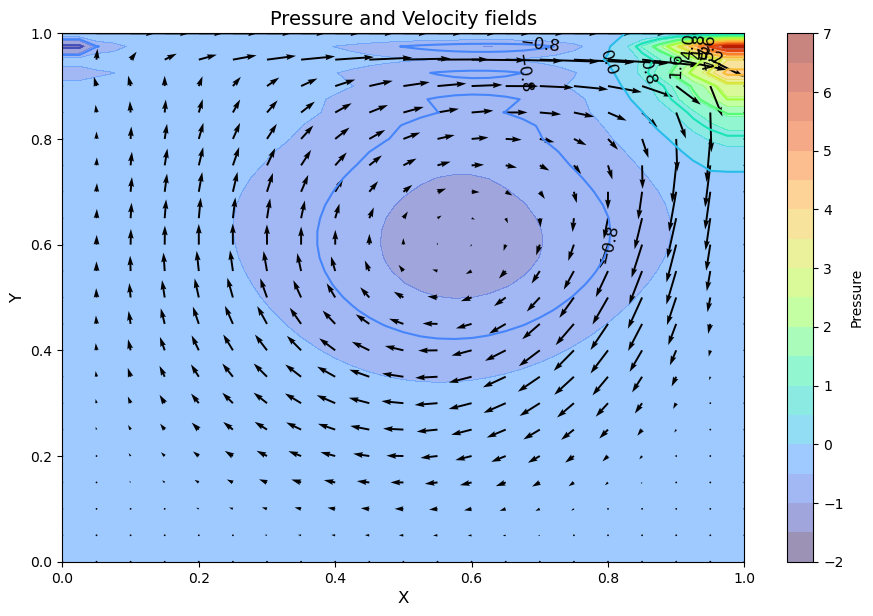

In [9]:
nt = 10000

start_time = time.time()

u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

end_time = time.time()
# Compute running time
running_time = end_time - start_time
print(f"Running time: {running_time} seconds")


# Create figure and set dpi and figure size
fig = plt.figure(figsize=(11,7), dpi=100)

# Contourf plot for pressure field with colorbar
cf = plt.contourf(X, Y, p, alpha=0.5, cmap='turbo', levels=20)
plt.colorbar(cf, label='Pressure')

# Contour plot for pressure field outlines
contour = plt.contour(X, Y, p, cmap='turbo', levels=10)
plt.clabel(contour, inline=False, fontsize=12, colors = 'black')

# Quiver plot for velocity field
quiv = plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 

# Setting labels for the x and y axes
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)

# Setting the title for the plot
plt.title('Pressure and Velocity fields', fontsize=14)

# Display the plot
plt.show()

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the txt file
with open('Ghia-1982.txt', 'r') as file:
    lines = file.readlines()

# Adjust the lines range to match your data
lines = lines[5:-7]  # Adjust these numbers

# Process lines to obtain data
data = [list(map(float, line.split())) for line in lines]

# Create DataFrame from data
df = pd.DataFrame(data, columns=['y', 'Re=100', 'Re=400', 'Re=1000', 'Re=3200', 'Re=5000', 'Re=7500', 'Re=10000'])

# Set y as index
df.set_index('y', inplace=True)

# Plotting
# plt.figure(figsize=(10,8))
# for column in df.columns:
#     plt.plot(df[column].values, df.index.values, label=column) # use .values to get numpy arrays

# plt.xlabel('u-velocity')
# plt.ylabel('y')
# plt.title('u-velocity for different y and Re')
# plt.legend()
# plt.gca().invert_yaxis()  # To invert y-axis
# plt.grid(True)
# plt.show()

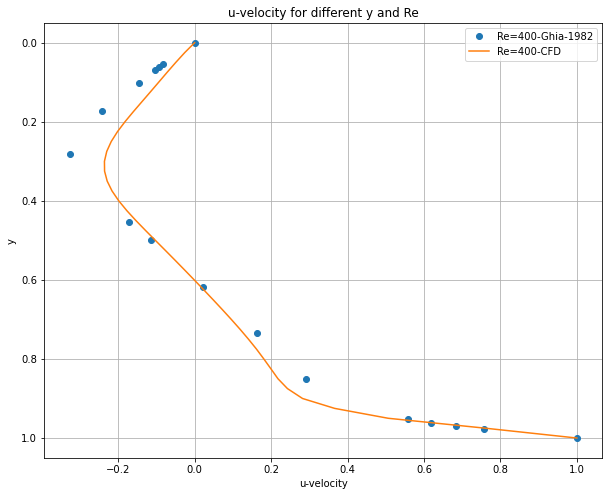

In [11]:
# Plotting
plt.figure(figsize=(10,8))

plt.plot(df['Re=400'].values, df.index.values, 'o', label='Re=400-Ghia-1982') # use .values to get numpy arrays
plt.plot(u[:,int(ny/2)]/c, y, label='Re=400-CFD') # 

plt.xlabel('u-velocity')
plt.ylabel('y')
plt.title('u-velocity for different y and Re')
plt.legend()
plt.gca().invert_yaxis()  # To invert y-axis
plt.grid(True)
plt.show()

### Try a case with Re = 1000 and what happens?

For a side-by-side efficiency comparison between Chorin's projection and the direct coupling method, we've replicated the direct coupling approach and executed it below.

In [12]:
def cavity_flow_direct(nt, u, v, dt, dx, dy, p, rho, nu):
    
    def build_up_b(b, rho, dt, u, v, dx, dy):

        b[1:-1, 1:-1] = (rho * (1 / dt * 
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                         (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                          2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                               (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                              ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))


        return b

    # This is another version of pressure_poisson function with l1norm_target
    def pressure_poisson_l1norm(p, dx, dy, b, l1norm_target):
        pn = np.empty_like(p)
        pn = p.copy()

        l1norm = 1
        small = 1e-8
        niter = 0
        while l1norm > l1norm_target:
            niter += 1   # count the number of iterations for convergence
            pn = p.copy()
            p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                              (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                              (2 * (dx**2 + dy**2)) -
                              dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                              b[1:-1,1:-1])

            p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
            p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
            p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
            p[-1, :] = 0        # p = 0 at y = 2
            l1norm = (np.sum(np.abs(p[:]-pn[:])) / (np.sum(np.abs(pn[:]))+small))

        return p, niter

    def velocity_u_update(u, dx, dy, dt, rho, p, un, vn):

        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                        un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                        dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                        nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
        return u

    def velocity_v_update(v, dx, dy, dt, rho, p, un, vn):

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                        (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                        (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                        (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                        (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        return v

    un = np.empty_like(u)
    vn = np.empty_like(v)
    pn = np.empty_like(p)
    b = np.zeros((ny, nx))
    small = 1e-8    
    for n in tqdm(range(nt)):
        un = u.copy()
        vn = v.copy()
        pn = p.copy()
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        #p = pressure_poisson(p, dx, dy, b)
        p, niter = pressure_poisson_l1norm(p, dx, dy, b, 1e-4)
        #print(niter)

        u = velocity_u_update(u, dx, dy, dt, rho, p, un, vn)
        v = velocity_v_update(v, dx, dy, dt, rho, p, un, vn)
        
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = c    # set velocity on cavity lid equal to c
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
    l1norm_u = (np.sum(np.abs(u[:]-un[:])) / (np.sum(np.abs(un[:]))+small))
    l1norm_v = (np.sum(np.abs(v[:]-vn[:])) / (np.sum(np.abs(vn[:]))+small))
    l1norm_p = (np.sum(np.abs(p[:]-pn[:])) / (np.sum(np.abs(pn[:]))+small))
    print("l1norm_u = ",  l1norm_u, "l1norm_v = ",  l1norm_v, "l1norm_p = ",  l1norm_p)
    return u, v, p

In [13]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 10000
c = 1

start_time = time.time()

u, v, p = cavity_flow_direct(nt, u, v, dt, dx, dy, p, rho, nu)

end_time = time.time()
# Compute running time
running_time = end_time - start_time
print(f"Running time of the direct coupling: {running_time} seconds")

start_time = time.time()

u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

end_time = time.time()
# Compute running time
running_time = end_time - start_time
print(f"Running time of the Chorin's projection: {running_time} seconds")

  0%|                                                                                         | 0/10000 [00:00<?, ?it/s]

  0%|                                                                                 | 8/10000 [00:00<02:08, 77.63it/s]

  0%|▏                                                                              | 26/10000 [00:00<01:14, 134.75it/s]

  2%|█▎                                                                            | 167/10000 [00:00<00:13, 707.21it/s]

  4%|███▏                                                                         | 418/10000 [00:00<00:06, 1410.58it/s]

  7%|█████▌                                                                       | 721/10000 [00:00<00:04, 1989.23it/s]

 11%|████████▍                                                                   | 1114/10000 [00:00<00:03, 2644.25it/s]

 16%|████████████▏                                                               | 1607/10000 [00:00<00:02, 3387.71it/s]

 22%|████████████████▋                                                           | 2189/10000 [00:00<00:01, 4158.93it/s]

 28%|█████████████████████▌                                                      | 2841/10000 [00:00<00:01, 4893.64it/s]

 35%|██████████████████████████▋                                                 | 3517/10000 [00:01<00:01, 5467.75it/s]

 42%|███████████████████████████████▊                                            | 4191/10000 [00:01<00:00, 5855.89it/s]

 48%|████████████████████████████████████▊                                       | 4837/10000 [00:01<00:00, 6038.88it/s]

 55%|█████████████████████████████████████████▉                                  | 5511/10000 [00:01<00:00, 6249.37it/s]

 62%|███████████████████████████████████████████████                             | 6185/10000 [00:01<00:00, 6396.99it/s]

 69%|████████████████████████████████████████████████████▏                       | 6859/10000 [00:01<00:00, 6498.74it/s]

 75%|█████████████████████████████████████████████████████████                   | 7509/10000 [00:01<00:00, 6489.11it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 8182/10000 [00:01<00:00, 6560.45it/s]

 89%|███████████████████████████████████████████████████████████████████▎        | 8855/10000 [00:01<00:00, 6609.53it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 9521/10000 [00:01<00:00, 6622.88it/s]

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5049.28it/s]


  0%|                                                                                         | 0/10000 [00:00<?, ?it/s]

  1%|█                                                                            | 139/10000 [00:00<00:07, 1388.61it/s]

l1norm_u =  2.0964336749894792e-06 l1norm_v =  2.8019156614369277e-06 l1norm_p =  2.349586199251818e-06
Running time of the direct coupling: 1.9819300174713135 seconds


  8%|██████▍                                                                      | 836/10000 [00:00<00:01, 4659.48it/s]

 16%|████████████                                                                | 1579/10000 [00:00<00:01, 5919.76it/s]

 23%|█████████████████▋                                                          | 2323/10000 [00:00<00:01, 6516.19it/s]

 31%|███████████████████████▎                                                    | 3064/10000 [00:00<00:01, 6834.80it/s]

 38%|████████████████████████████▉                                               | 3803/10000 [00:00<00:00, 7023.25it/s]

 45%|██████████████████████████████████▌                                         | 4549/10000 [00:00<00:00, 7165.71it/s]

 53%|████████████████████████████████████████▎                                   | 5297/10000 [00:00<00:00, 7262.85it/s]

 60%|█████████████████████████████████████████████▊                              | 6024/10000 [00:00<00:00, 7208.37it/s]

 67%|███████████████████████████████████████████████████▎                        | 6745/10000 [00:01<00:00, 7174.23it/s]

 75%|████████████████████████████████████████████████████████▋                   | 7463/10000 [00:01<00:00, 7083.82it/s]

 82%|██████████████████████████████████████████████████████████████              | 8172/10000 [00:01<00:00, 6848.69it/s]

 89%|███████████████████████████████████████████████████████████████████▍        | 8880/10000 [00:01<00:00, 6914.45it/s]

 96%|█████████████████████████████████████████████████████████████████████████   | 9619/10000 [00:01<00:00, 7053.40it/s]

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6782.70it/s]

l1norm_u =  9.146630711997816e-08 l1norm_v =  1.2481511707631306e-07 l1norm_p =  8.195025302473762e-08
Running time of the Chorin's projection: 1.4756381511688232 seconds


**Chorin's projection is more efficient than the direct coupling approach!**